## Forward vs Backward Iteration for Production Chains

Code to compute equilibrium prices and actions using both the forward and backward contracting approaches.

In [2]:
"""
Computes equilibrium prices and actions in the continuum case.
Uses the fact that the forward pricing function is the fixed
point of a contraction mapping T.  Starts with a guess and then
iterates with T.

John Stachurski, 2010, 2017

"""

import numpy as np
from scipy.optimize import bisect, brentq, fminbound
from scipy.interpolate import interp1d

class RPS:
    """
    Recursive Price System.
    Instances contain parameters and functions specifying the system,
    as well as functions to compute equilibrium prices and actions.
    """
    
    def __init__(self, 
                 delta=1.05,                # transaction cost
                 c=lambda t: t + 10 * t**2, # production cost
                 S=2.228,                   # guess of equilib price at 1  
                 gridsize=500):
        
        self.delta, self.S, self.c = delta, S, c
        self.grid = np.linspace(0, 1, gridsize)
        self.prices = np.zeros(gridsize)  # Initial guess
        self.steps = None                 # Points at which trade occurs
        self.tstar = None                 # Optimal choice, a function
        self.steps = None
        
    
    def forward_T(self, p):
        """
        Operator that updates prices using forward iteration.
        """
        p_func = interp1d(self.grid, p)
        new_p = np.empty_like(self.grid)
        for i,s  in enumerate(self.grid):
            h = lambda a: p_func(s + a) - self.c(a)
            searchgrid = np.linspace(0, 1 - s, num=200)
            v1 = np.max(h(searchgrid))     # Best interior choice
            v2 = self.S - self.c(1 - s)   # Choice at boundary
            new_p[i] = max(v1, v2)
        return (1 / self.delta) * new_p

    
    def compute_prices_forward(self, tol=1e-3):
        p = self.prices
        while 1:
            new_p = self.forward_T(p)
            error = max(abs(new_p - p))
            if error < tol:
                break
            p = new_p
        self.prices = new_p
        
        
    def compute_prices_backwards(self, tol=1e-3):
        """
        Iteration in the backward contracting algorithm, starting from p = c.
        """
        self.prices = self.c(self.grid)    # Initial condition is c(s), as an array
        new_prices = np.empty_like(self.prices)
        error = tol + 1
        while error > tol:
            for i, s in enumerate(self.grid):
                p = interp1d(self.grid, self.prices)
                Tp = lambda t: self.delta * p(t) + self.c(s - t)
                new_prices[i] = Tp(fminbound(Tp, 0, s))
            error = np.max(np.abs(self.prices - new_prices))
            self.prices = new_prices
    
    
    def compute_equilibrium_p1(self):
        """
        Sets self.p1 to the equilibrium unit cost in a forward iteration process,
        given self.delta and the cost function.
        """
        u = self.c(1)
        while 1:
            self.p1 = u
            self.compute_prices_forward()
            pz = self.prices[0]
            print(u, pz)
            if pz < 1e-4:
                break
            u = u * 0.9
        self.p1 = u

        
    def compute_tstar(self):
        """
        Optimal choice of step size at the equilibrium price.
        """
        actions = np.empty_like(self.grid)
        p_func = interp1d(self.grid, self.prices)
        for i, s in enumerate(self.grid):
            h = lambda a: p_func(s + a) - self.c(a)
            searchgrid = np.linspace(0, 1 - s, num=200)
            action = searchgrid[np.argmax(h(searchgrid))]
            actions[i] = action
        self.tstar = interp1d(self.grid, actions)


Generate an instance of the model using the default parameters supplied above.

In [3]:
m = RPS()

Compute prices using the forward iteration algorithm.

In [4]:
m.compute_prices_forward()
fwd_price = m.prices

Compute prices using the backward iteration algorithm.

In [5]:
m.compute_prices_backwards()
bwd_price = m.prices

Check that final price $S$ used in code above was correct

In [6]:
bwd_price[-1]

2.228077932699752

In [7]:
m.S

2.228

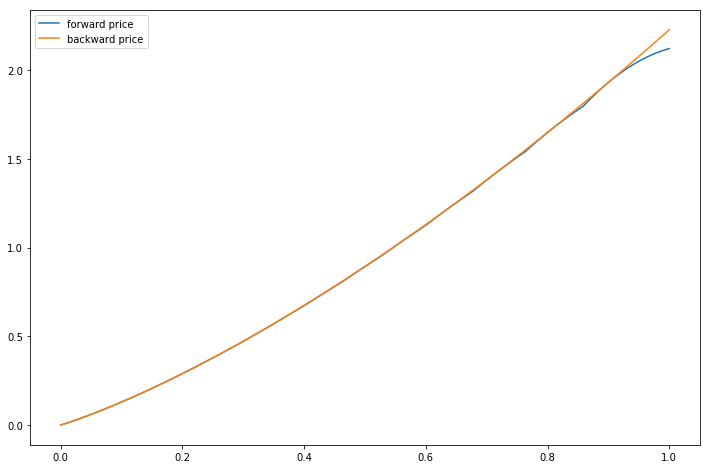

In [9]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(m.grid, fwd_price, label='forward price')
ax.plot(m.grid, bwd_price, label='backward price')
ax.legend()

plt.show()

Let's take a closer look at the top right corner.

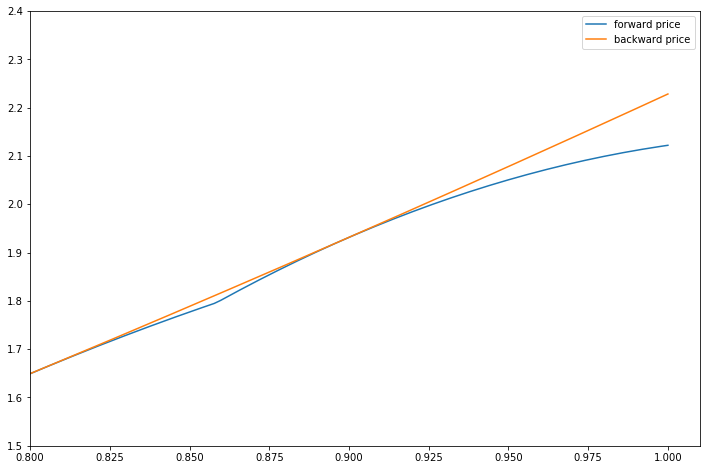

In [14]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(m.grid, fwd_price, label='forward price')
ax.plot(m.grid, bwd_price, label='backward price')
ax.set_xlim(0.8, 1.01)
ax.set_ylim(1.5, 2.4)
ax.legend()

plt.show()

In [8]:
m.compute_tstar()

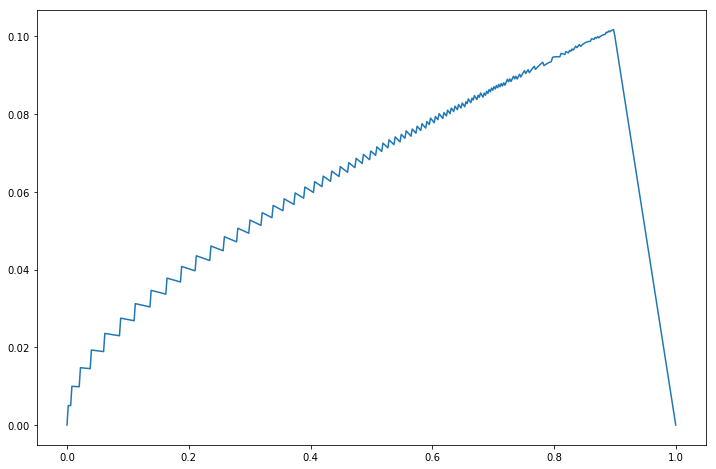

In [9]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(m.grid, m.tstar(m.grid))

plt.show()